# Pokemon type classifier

This project takes a dataset with Pokémon sprites and trains a CNN to classify whether a Pokémon belongs to a certain type (e.g. water: true or false). It is meant as a demo to show how DVC can be used in deep learning scenarios.

## Imports and parameters

In [1]:
import math
import os
import re
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, log_loss, accuracy_score, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tqdm import tqdm
import yaml

In [2]:
def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()

## Data preprocessing

In [6]:
# Process Pokémon and one-hot encode the types

def preprocess_training_labels(dataset) -> pd.DataFrame:
    pokemon = pd.read_csv(PROJECT_ROOT / "data/external" / dataset)
    pokemon = pokemon[["pokedex_number", "name", "type1", "type2"]]

    # Create one-hot columns for each type
    df_one_hot = pd.get_dummies(pokemon.type1.str.capitalize(), prefix='is', prefix_sep='')+pd.get_dummies(pokemon.type2.str.capitalize(), prefix='is', prefix_sep='')
    df_one_hot = df_one_hot.clip(0, 1)
    pokemon = pd.merge(pokemon, df_one_hot, left_index=True, right_index=True)
            
    # Save output
    os.makedirs(PROJECT_ROOT / "data/processed")
    pokemon.to_csv(PROJECT_ROOT / "data/processed" / 'pokemon.csv', index=False)
            
    return(pokemon)

pokemon = preprocess_training_labels("stats/pokemon-gen-1-8.csv")
pokemon.head()

,pokedex_number,name,type1,type2,isBug,isDark,isDragon,isElectric,isFairy,isFighting,...,isGhost,isGrass,isGround,isIce,isNormal,isPoison,isPsychic,isRock,isSteel,isWater
0,1,Bulbasaur,grass,poison,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,2,Ivysaur,grass,poison,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,3,Venusaur,grass,poison,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,4,Charmander,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Charmeleon,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Process image data

def preprocess_training_data(dataset) -> pd.DataFrame:

    data_directory_images = PROJECT_ROOT / "data/external" / dataset
    output_directory = PROJECT_ROOT / "data/processed" / "pokemon"

    pokemon = pd.read_csv(PROJECT_ROOT / "data/processed" / 'pokemon.csv')
    pokemon["imagePath"] = np.nan

    # Remove processed folder and create empty new one
    try:
        shutil.rmtree(output_directory)
        os.mkdir(output_directory)
    except:
        os.mkdir(output_directory)

    # Copy images to processed folder
    for image in os.listdir(data_directory_images):
        pokemon_id = image.split('.')[0]

        # Add leading zeroes to ID
        pokemon_id = pokemon_id.zfill(3)

        # Images with no variety (e.g. "211.png")
        if pokemon_id.isnumeric():

            # Copy to processed folder
            src = data_directory_images / image
            dst = os.path.join(output_directory, pokemon_id + ".png")
            shutil.copyfile(src, dst)

    # Set image path in data frame
    pokemon['imagePath'] = pokemon['pokedex_number'].apply(lambda x: os.path.join(output_directory, str(x).zfill(3) + '.png'))

    # Drop Pokemon without image path
    pokemon = pokemon.dropna(subset=["imagePath"])
    
    # Save pokemon.csv with image paths
    pokemon.to_csv(PROJECT_ROOT / "data/processed" / 'pokemon-with-image-paths.csv', index=False)
    
    return(pokemon)

pokemon = preprocess_training_data("pokemon-gen-1-8")
pokemon.head()

,pokedex_number,name,type1,type2,isBug,isDark,isDragon,isElectric,isFairy,isFighting,...,isGrass,isGround,isIce,isNormal,isPoison,isPsychic,isRock,isSteel,isWater,imagePath
0,1,Bulbasaur,grass,poison,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,/Users/robdewit/Documents/dtc-workshop/data/pr...
1,2,Ivysaur,grass,poison,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,/Users/robdewit/Documents/dtc-workshop/data/pr...
2,3,Venusaur,grass,poison,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,/Users/robdewit/Documents/dtc-workshop/data/pr...
3,4,Charmander,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/Users/robdewit/Documents/dtc-workshop/data/pr...
4,5,Charmeleon,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/Users/robdewit/Documents/dtc-workshop/data/pr...


## Load training data and create split

In [9]:
# Load images as training data

def load_training_data(labels) -> np.array:
    train_image = []

    for i in tqdm(range(labels.shape[0])):

        img = tf.keras.utils.load_img(labels.iloc[i]["imagePath"], color_mode='rgba')
        img = tf.keras.utils.img_to_array(img)
        img = img/255
        train_image.append(img)
    X = np.array(train_image)
    
    return(X)

X = load_training_data(pokemon)
X.shape
    
# Set dimensions for input sizes later on
model_image_size_x = len(X[1])
model_image_size_y = len(X[2])

100%|█████████████████████████████████████████████████████████| 801/801 [00:04<00:00, 188.90it/s]


In [10]:
# Create labels

def create_labels(labels):
    return(pokemon[["is" + "Water"]])

y = create_labels(pokemon)

In [11]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 475, 475, 4) (640, 1)
(161, 475, 475, 4) (161, 1)


## Define model and train

In [15]:
img_input = layers.Input(shape=(model_image_size_x, model_image_size_y, 4))

model = Sequential()

model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(model_image_size_x, model_image_size_y, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.2))

model.add(Dense(8, activation="relu"))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(1, activation="sigmoid"))

# Legacy needed for M1/M2
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001) #Adam, RMSprop or SGD

model.compile(
    loss='binary_crossentropy'
    , optimizer=optimizer
    , metrics=[keras.metrics.AUC()]
#     , metrics=[keras.metrics.Recall()]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 471, 471, 4)       404       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 235, 235, 4)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 235, 235, 4)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 231, 231, 4)       404       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 115, 115, 4)      0         
 2D)                                                             
                                                                 
 dense_2 (Dense)             (None, 115, 115, 8)      

In [16]:
# Now train the model

def calculate_class_weights(y_train):
    ratio_true = sum(y_train["isWater"] == 1) / len(y_train["isWater"])
    ratio_false = sum(y_train["isWater"] != 1) / len(y_train["isWater"])

    return {0: ratio_true, 1: ratio_false}


estimator = model.fit(X_train, y_train, 
                      validation_data=(X_test, y_test),
                      class_weight= calculate_class_weights(y_train),
                      epochs=10, 
                      batch_size=120,
                      verbose=1)

Epoch 1/10


2023-02-09 13:56:42.826314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.3656 - auc_1: 0.4994

2023-02-09 13:56:48.198642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 6s 725ms/step - loss: 0.3656 - auc_1: 0.4994 - val_loss: 0.7082 - val_auc_1: 0.5742
Epoch 2/10
6/6 [==============================] - 3s 593ms/step - loss: 0.2542 - auc_1: 0.6853 - val_loss: 0.7823 - val_auc_1: 0.6644
Epoch 3/10
6/6 [==============================] - 3s 537ms/step - loss: 0.2383 - auc_1: 0.8034 - val_loss: 0.7447 - val_auc_1: 0.6584
Epoch 4/10
6/6 [==============================] - 3s 521ms/step - loss: 0.2365 - auc_1: 0.8078 - val_loss: 0.7416 - val_auc_1: 0.6642
Epoch 5/10
6/6 [==============================] - 3s 525ms/step - loss: 0.2230 - auc_1: 0.8563 - val_loss: 0.7484 - val_auc_1: 0.6691
Epoch 6/10
6/6 [==============================] - 3s 528ms/step - loss: 0.2180 - auc_1: 0.8473 - val_loss: 0.7001 - val_auc_1: 0.6530
Epoch 7/10
6/6 [==============================] - 3s 543ms/step - loss: 0.2084 - auc_1: 0.8682 - val_loss: 0.7215 - val_auc_1: 0.6520
Epoch 8/10
6/6 [==============================] - 3s 517ms/step - loss: 0

## Plot training history and save model

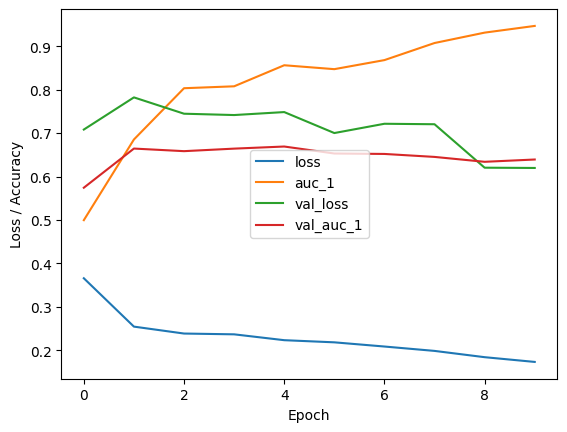

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...metrics
......auc
.........vars
............0
............1
............2
............3
......mean
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-09 13:59:27         4023
metadata.json                                  2023-02-09 13:59:27           64
variables.h5                                   2023-02-09 13:59:27       461040


In [19]:
# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')

for k in estimator.history.keys():
    plt.plot(estimator.history[k], label = k) 
plt.legend(loc='best')

os.makedirs(PROJECT_ROOT / "outputs")
plt.savefig(PROJECT_ROOT / "outputs" / "train_history.png", dpi=150, bbox_inches='tight', pad_inches=0)
plt.show()

# Save model itself
pickle.dump(estimator, open(PROJECT_ROOT / "outputs" / "model.pckl", "wb"))

## Validation

2023-02-09 13:59:35.301689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.9194044


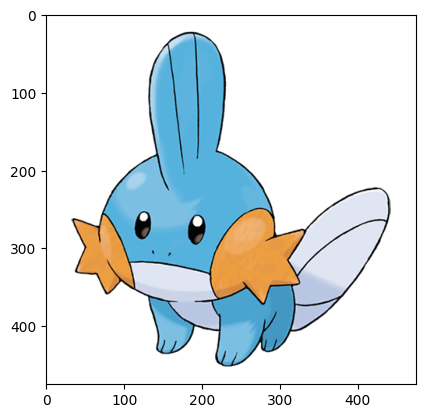

In [20]:
def predict_pokemon(id: str, verbose=0):
    
    id = id.zfill(3)
    
    img = tf.keras.utils.load_img(PROJECT_ROOT/"data/processed"/'pokemon'/f'{id}.png', color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255


    classes = y
    proba = model.predict(img.reshape(1,475,475,4), verbose=verbose)
    
    plt.clf()
    plt.imshow(img)
    
    return proba[0][0]

print(predict_pokemon("258"))

In [21]:
# Predict all Pokémon
predictions = model.predict(X) > 0.5

26/26 [==============================] - 1s 30ms/step


In [22]:
# Calculate metrics
metrics = {}

metrics["acc"] = float(accuracy_score(y, predictions))
metrics["precision"] = float(precision_score(y, predictions))
metrics["recall"] = float(recall_score(y, predictions))
metrics["f1"] = float(f1_score(y, predictions))


print(metrics)

with open(PROJECT_ROOT / "outputs" / "metrics.yaml", 'w') as file:
    yaml.dump(metrics, file, default_flow_style=False)

{'acc': 0.8751560549313359, 'precision': 0.5786802030456852, 'recall': 0.8702290076335878, 'f1': 0.6951219512195121}


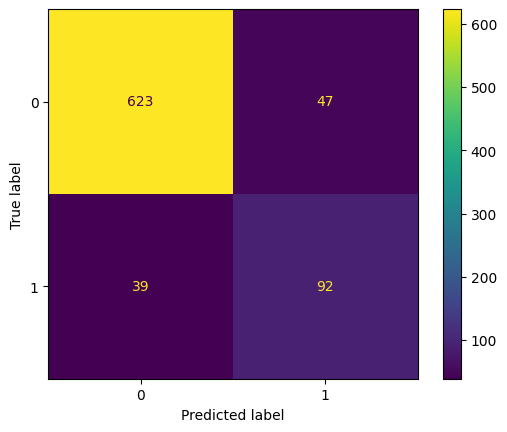

In [16]:
# Plot confusion matrix
cm = confusion_matrix(y, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.savefig(PROJECT_ROOT / "outputs" / "confusion_matrix.png", dpi=150, bbox_inches='tight', pad_inches=0)
plt.show()

*Attribution*:

- https://github.com/benckx/dnn-movie-posters
- https://medium.com/m2mtechconnect/classifying-pok%C3%A9mon-images-with-machine-learning-79b9bc07c080
- https://www.kaggle.com/datasets/rounakbanik/pokemon